In [ ]:
import dask
import dask.dataframe as dd
import pandas as pd
from pathlib import Path
import numpy as np

from finx_option_data.transforms import (
    transform_last_trading_day_human, 
    transform_add_last_trading_day_week_number,
    transform_columns_datetime, 
    transform_symbol_underlying, 
    transform_add_strike,
    transform_add_call_put,
    find_matching_row,
)
from finx_option_data.calculations import (
    calc_front_back_delta_diff,
    calc_front_back_mid_diff,
    calc_front_back_volitality_diff,
    calc_front_back_theta_diff
)
from finx_option_data.utils import timeit_context

In [21]:
from finx_option_data.configs import Config
config = Config(".env.prod")
engine = config.engine_metrics

2022-05-17 14:42:46,513 INFO sqlalchemy.engine.Engine select version()
2022-05-17 14:42:46,514 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-05-17 14:42:46,630 INFO sqlalchemy.engine.Engine select current_schema()
2022-05-17 14:42:46,653 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-05-17 14:42:46,721 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2022-05-17 14:42:46,721 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-05-17 14:42:46,789 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-05-17 14:42:46,793 INFO sqlalchemy.engine.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2022-05-17 14:42:46,799 INFO sqlalchemy.engine.Engine [generated in 0.00607s] {'name': 'metric_back_front_vol'}
2022-05-17 14:42:46,883 INFO sqlalchemy.engine.Engine COMMIT


In [23]:
engine

This is a data processing pipline. 

Steps, 
- Extract the data from S3 (atm, read from local fine drive)
- Do transforms
- Filter for just SPY data
- Aggregate over the last hour of the market (3-4pm US/Eastern).
- Construct the -Friday+Monday comp(pd.DataFrame) object
- Calculate diffs (volatility, mid price, delta)
- Generate summary plot

Todos
- [ ] for lastTradingDayWeekNumber_f, save metrics for (vol_diff, mid_diff, delta_diff, vega_diff, gamma_diff wrt (DTE, vols=30,40,50,60,70))

In [7]:
# dask the entire directory
# df = dd.read_parquet("/Users/vifo/work/lsc/finx-option-data/data/raw/2022/4/25/*.parquet.gzip")

# pandas read the entire directory
data_dir = Path('/Users/vifo/work/lsc/finx-option-data/data/raw/2022/4/25/1650878173.parquet.gzip')
df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet.gzip')
)

# single_file = "/Users/vifo/work/lsc/finx-option-data/data/raw/2022/4/25/1650878196.parquet.gzip"
# df = dd.read_parquet(single_file)
# df = pd.read_parquet(single_file)

In [8]:
def transform(df):
    with timeit_context("transform_columns_datetime"):
        df = transform_columns_datetime(df)

    with timeit_context("transform_symbol_underlying"):
        df = transform_symbol_underlying(df)
    
    with timeit_context("transform_add_strike"):
        df = transform_add_strike(df)
    
    with timeit_context("transform_add_call_put"):
        df = transform_add_call_put(df)

    with timeit_context("transform_last_trading_day_human"):
        df = transform_last_trading_day_human(df)

    with timeit_context("transform_add_last_trading_day_week_number"):
        df = transform_add_last_trading_day_week_number(df)
    
    return df

tdf = transform(df)

2022-05-17 14:38:34.430 | DEBUG    | finx_option_data.utils:timeit_context:18 - 1.23 [transform_columns_datetime]
2022-05-17 14:38:47.061 | DEBUG    | finx_option_data.utils:timeit_context:18 - 12.63 [transform_symbol_underlying]
2022-05-17 14:38:59.709 | DEBUG    | finx_option_data.utils:timeit_context:18 - 12.65 [transform_add_strike]
2022-05-17 14:39:02.414 | DEBUG    | finx_option_data.utils:timeit_context:18 - 2.70 [transform_add_call_put]
2022-05-17 14:39:51.514 | DEBUG    | finx_option_data.utils:timeit_context:18 - 49.10 [transform_last_trading_day_human]
2022-05-17 14:40:28.633 | DEBUG    | finx_option_data.utils:timeit_context:18 - 37.12 [transform_add_last_trading_day_week_number]


In [9]:
def filter_df(df, 
    underlyings: list=None, 
    last_trading_day_min=None, 
    last_trading_day_max=None
):
    
    if underlyings is not None:
        df = df[ df['underlying'].isin(underlyings)].copy()
    
    if last_trading_day_min is not None:
        df = df[last_trading_day_min <= df["lastTradingDay"]].copy()
    
    if last_trading_day_max is not None:
        df = df[df["lastTradingDay"] <= last_trading_day_max].copy()
        
    return df

tdf = filter_df(tdf, underlyings=["SPY"])

In [10]:
x = pd.to_datetime('2022-04-25 20:00')

tdf = (tdf.
     query("@x <= sampleTimeInLong").
     groupby("symbol").
     agg({

        "ask": "last",
        "bid": "last", 
        "strike": "last", 
        "call_put": "last", 
        "delta": "last",
        "theta": "last",
        "lastTradingDay": "last", 
        "quoteTimeInLong": "last",
        "daysToExpiration": "last",
        "volatility": "last",
        "lastTradingDayDes": "last",
        "lastTradingDayWeekNumber": "last",

    }).sort_values(["symbol"])
).copy()

In [11]:
idf = tdf.copy()

def gen_friday_and_following_monday(input_df):
    """
    Generate a df with Friday data as Front following Monday (t+1 market days) as Back

    Input:
        input_df(pd.DataFrame): df

    Returns:
        df(pd.DataFrame): with finx_desc=fm3dte_calendar
    """
    df = input_df.copy()
    for _, grouped in df.groupby(["strike", "call_put"]):
        for idx, row in grouped.iterrows():
            last_ew_row = find_matching_row(df, row, dte_diff=-3)
            df.loc[idx, "matchingSymbol"] = np.NaN if last_ew_row is None else last_ew_row.name
    comp = pd.merge(df, df, left_on="matchingSymbol", right_index=True, suffixes=("_f", "_b"))
    comp["finx_desc"] = "fm3dte_calendar"
    return comp


def gen_friday_and_following_friday(input_df):
    """
    Generate a df with Friday data as Front following Friday (t+7 market days) as Back

    Input:
        input_df(pd.DataFrame): df

    Returns:
        df(pd.DataFrame): with finx_desc=ff7dte_calendar
    """
    df = input_df.copy()
    for _, grouped in df.groupby(["strike", "call_put"]):
        for idx, row in grouped.iterrows():
            last_ew_row = find_matching_row(df, row, dte_diff=-7)
            df.loc[idx, "matchingSymbol"] = np.NaN if last_ew_row is None else last_ew_row.name
    comp = pd.merge(df, df, left_on="matchingSymbol", right_index=True, suffixes=("_f", "_b"))
    comp["finx_desc"] = "ff7dte_calendar"
    return comp

comp = gen_friday_and_following_monday(idf)

DTE = [10]


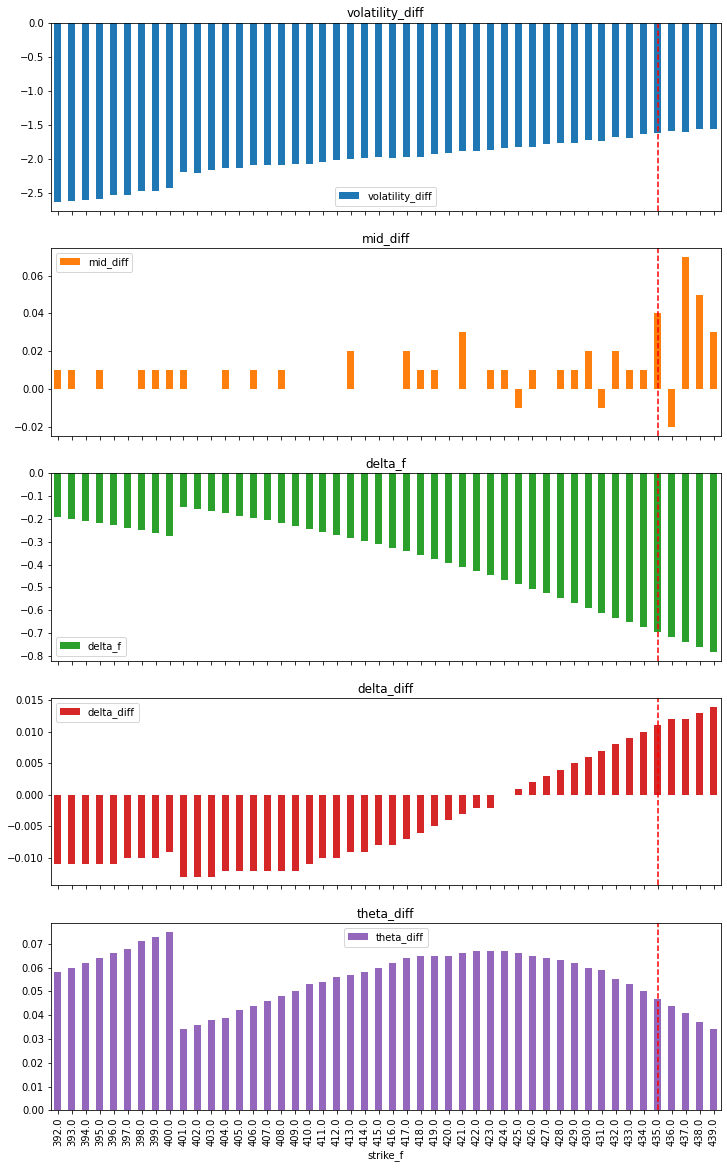

In [12]:
# def calc_front_back_mid_diff(df) -> None:
#     """
#     Calc the mid diff between -AskBid_front + AskBid_back.
#     Stores in mid_[f|b|diff].
#     Returns: None
#     """
#     df["mid_f"] = (df["ask_f"]-df["bid_f"])
#     df["mid_b"] = (df["ask_b"]-df["bid_b"])
#     df["mid_diff"] = - df["mid_f"] + df["mid_b"]
#     return None

# def calc_front_back_volitality_diff(df) -> None:
#     """
#     Calc the volatility diff between -volatility_f + volatility_b
#     Stores in volatility_diff.
#     Returns: None
#     """
#     df["volatility_diff"] = -df["volatility_f"] + df["volatility_b"]
#     return None



calc_front_back_mid_diff(comp)
calc_front_back_volitality_diff(comp)
calc_front_back_delta_diff(comp)
calc_front_back_theta_diff(comp)

plot_df = comp.query("lastTradingDayDes_f == 'EW1'")

print(f"DTE = {plot_df.daysToExpiration_f.unique()}")

call_put = "p"

# plot df
plot_df = (
    plot_df[["volatility_diff", "mid_diff", "delta_f", "delta_diff", "theta_diff", "call_put_f", "strike_f"]].
    query(f"call_put_f == '{call_put}'").
    query("-0.8 < delta_f and delta_f < -0.1").
    set_index("strike_f")
)

# gets subplots
axes = plot_df.plot.bar(subplots=True, figsize=(12, 20))

# determine x value and plot_df index for ATM (50 delta) strike
delta_50_index_value = plot_df.delta_f.add(0.7).abs().idxmin()
x_value = plot_df.index.searchsorted(delta_50_index_value)

# highlight the ATM strike
for ax in axes:
    ax.axvline(x_value, color='red', linestyle='dashed')

In [24]:
xdf = (comp.query(f"call_put_f == '{call_put}'").
    query("-0.8 < delta_f and delta_f < -0.1").
    set_index("strike_f"))

df_to_save = xdf[xdf.index == delta_50_index_value][["lastTradingDayWeekNumber_f", "mid_diff", "volatility_diff", "delta_diff", "delta_f", "daysToExpiration_f"]]

# cols = ["lastTradingDayWeekNumber_f", "mid_diff", "volatility_diff", "delta_diff", "delta_f", "daysToExpiration_f"]


# axes = xdf.query("daysToExpiration_f == 4")["mid_diff"].plot.bar(subplots=True, figsize=(12, 4))

# # determine x value and plot_df index for ATM (50 delta) strike
# delta_50_index_value = plot_df.delta_f.add(0.5).abs().idxmin()
# x_value = plot_df.index.searchsorted(delta_50_index_value)

# # highlight the ATM strike
# for ax in axes:
#     ax.axvline(x_value, color='red', linestyle='dashed')

# # comp["matchingSymbol"]
# # axes = xdf.query("daysToExpiration_f == 18")[cols].plot.bar(subplots=True, figsize=(12, 20))

In [35]:
# df_to_save("metrics_v1", con=engine, index=False)
from sqlalchemy import create_engine
conn_str = create_engine(config.metrics_postgres_connstr)
conn_str

engine = create_engine(conn_str)


AttributeError: 'Engine' object has no attribute '_instantiate_plugins'